In [1]:
import gpytorch
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) # p(f)

### Prepare data

/home/virtualx/anaconda3/envs/test_bayesian/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/virtualx/anaconda3/envs/test_bayesian/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Text(0.5, 1.0, 'Test data')

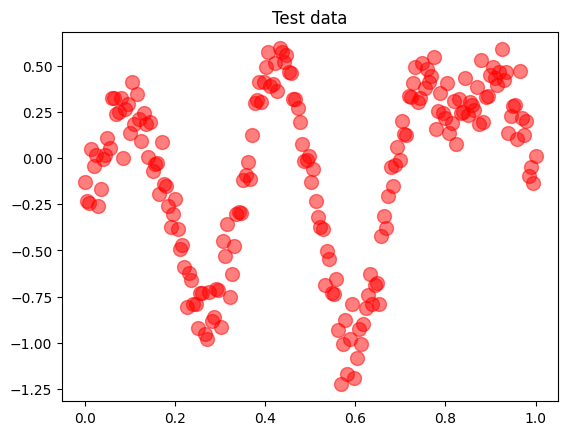

In [3]:
# x = torch.linspace(0., 1., 200)\
seed = 22


x = np.linspace(0., 1., 200)
np.random.seed(seed)
torch.manual_seed(seed)
np.random.shuffle(x)
x = torch.from_numpy(x).float()

RBF_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
gp = ExactGPModel(
    train_x=None,
    train_y=None,
    likelihood=gpytorch.likelihoods.GaussianLikelihood(), # p(y|f)
    kernel=RBF_kernel
)

true_lengthscale = 0.1
true_noise = 0.1
gp.covar_module.base_kernel.lengthscale = true_lengthscale
gp.eval()
f_preds = gp(x) 
y = f_preds.rsample().detach() + true_noise * torch.randn(len(x))
plt.plot(x, y, "ro", ms=10, alpha=0.5)
plt.title("Test data")

In [4]:
split_n = 50
eval_x = x[split_n:]
x = x[:split_n]
eval_y = y[split_n:]
y = y[:split_n]

In [5]:
test_x = torch.linspace(0., 1., 100)

Text(0.5, 1.0, 'Train data')

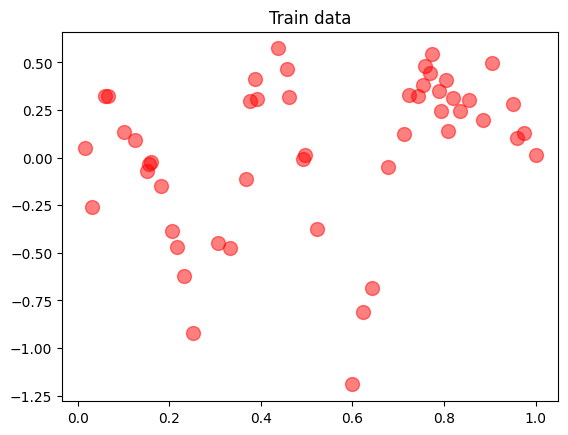

In [6]:
plt.plot(x, y, "ro", ms=10, alpha=0.5)
plt.title("Train data")

### Sanae's GP implementation

In [7]:
class RBFKernel(gpytorch.kernels.Kernel):
    def __init__(self, log_lengthscale_prior=None):
        self.has_lengthscale=True
        super(RBFKernel, self).__init__(has_lengthscale=True)
        self.register_parameter(name="isp_scale", 
                                parameter=torch.nn.Parameter(torch.zeros(1)))
        
    @property
    def scale(self):
        return torch.nn.functional.softplus(self.isp_scale)
        
    def forward(self, x1, x2, **params):
        x1_ = x1.div(self.lengthscale * np.sqrt(2))
        x2_ = x2.div(self.lengthscale * np.sqrt(2))
        # make covariance grid
        diff = torch.sum((x1_[:, None] - x2_[None, :])**2, -1)
        res = torch.exp(-diff) * self.scale
        return res

### Error vs MLL vs CMLL

In [8]:
lengthscale_array = torch.linspace(0.001, 0.3, 300)

tensor(0.1000)


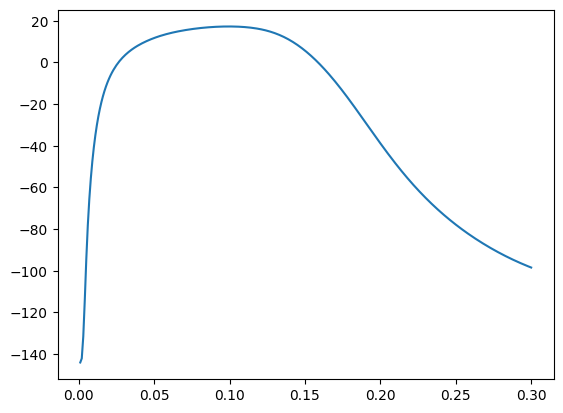

In [9]:
error_ll = []

for kernel_ll in lengthscale_array:
    
    kernel = RBFKernel()
    kernel.lengthscale = kernel_ll
    noise = torch.tensor([true_noise])

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise_covar.noise = noise
    gp = ExactGPModel(
        train_x=x,#[:40],
        train_y=y,#[:40],
        likelihood=likelihood,
        kernel=kernel
    )

    gp.eval()
    likelihood.eval()
    f_preds = gp(eval_x)
    y_preds = likelihood(f_preds)

#     error = ((f_preds.mean[:10] - eval_y[:10])**2).mean()
#     error = ((f_preds.mean - eval_y)**2).mean()
    error = y_preds.log_prob(eval_y)
    
    error_ll.append(error.item())

plt.plot(lengthscale_array, error_ll)

print(lengthscale_array[np.argmax(error_ll)])

In [10]:
def get_log_mll(gp, x, y):
    N = len(x)
    covar_matrix = gp.covar_module(x,x).evaluate()
    covar_matrix += gp.likelihood.noise * torch.eye(N)
    log_mll = - 0.5 * (y.T @ torch.inverse(covar_matrix)) @ y 
    log_mll += - 0.5 * torch.logdet(covar_matrix)
    log_mll += - 0.5 * N * np.log(2 * np.pi)

    return log_mll

/tmp/ipykernel_2534131/1063057985.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  log_mll = - 0.5 * (y.T @ torch.inverse(covar_matrix)) @ y


tensor(0.1030)


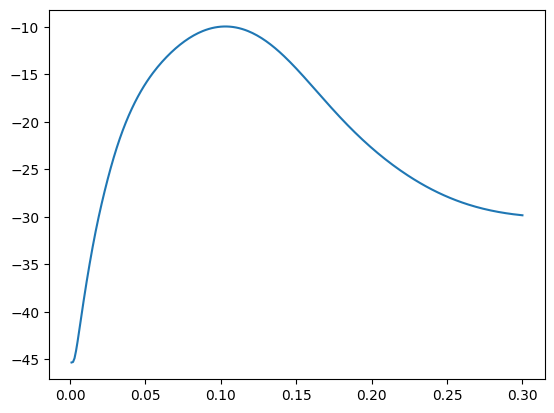

In [11]:
ml_ll = []

for kernel_ll in lengthscale_array:
    kernel = RBFKernel()
    kernel.lengthscale = kernel_ll
    noise = torch.tensor([true_noise])

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise_covar.noise = noise
    gp = ExactGPModel(
        train_x=x,#[:40],
        train_y=y,#[:40],
        likelihood=likelihood,
        kernel=kernel
    )

    gp.eval()
    likelihood.eval()
    
    ml_ll.append(get_log_mll(gp, x, y).item())

plt.plot(lengthscale_array, ml_ll)
print(lengthscale_array[np.argmax(ml_ll)])

tensor(0.1070)


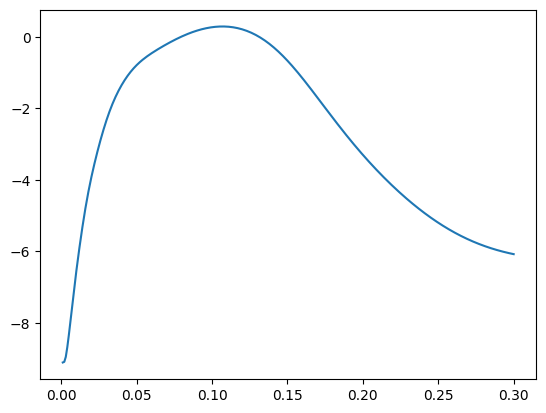

In [12]:
all_cml_ll = []
all_cml_error = []

m = 40
# m = 20
n_orders = 10

for _ in range(n_orders):
    cml_ll = []
    cml_error = []
    
    order = np.arange(len(x))
    np.random.shuffle(order)
    xm, ym = x[order[:m]], y[order[:m]]
    x_, y_ = x[order[m:]], y[order[m:]]

    for kernel_ll in lengthscale_array:

        kernel = RBFKernel()
        kernel.lengthscale = kernel_ll
        noise = torch.tensor([true_noise])

        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood.noise_covar.noise = noise
        gp = ExactGPModel(
            train_x=xm,
            train_y=ym,
            likelihood=likelihood,
            kernel=kernel
        )

        gp.eval()
        likelihood.eval()

        cml_ll.append((get_log_mll(gp, x, y) - get_log_mll(gp, xm, ym)).item())
        
#         f_preds = gp(x_)
#         y_preds = likelihood(f_preds)
#         error = y_preds.log_prob(y_)
#         cml_error.append(error)

        
    all_cml_ll.append(cml_ll)
#     all_cml_error.append(cml_error)

all_cml_ll = np.array(all_cml_ll)
# all_cml_error = np.array(all_cml_error)
plt.plot(lengthscale_array, all_cml_ll.mean(0))
print(lengthscale_array[np.argmax(all_cml_ll.mean(0))])

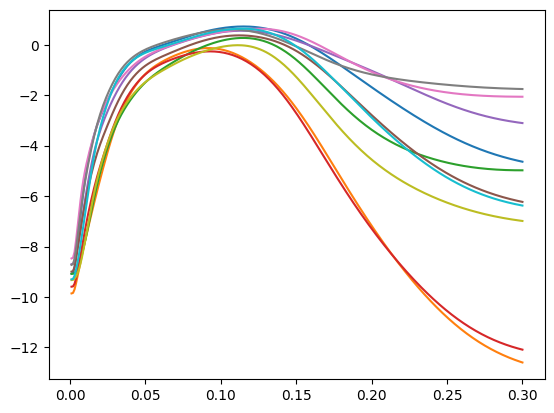

In [13]:
for i in range(n_orders):
    plt.plot(lengthscale_array, all_cml_ll[i])
# plt.plot(lengthscale_array, all_cml_ll[1])
# plt.plot(lengthscale_array, all_cml_ll[2])
# plt.plot(lengthscale_array, all_cml_ll[4])
# plt.plot(lengthscale_array, all_cml_ll[5])

In [14]:
def rescale(lst):
    lst = np.array(lst)
    return (lst - np.min(lst)) / (np.max(lst - np.min(lst)))

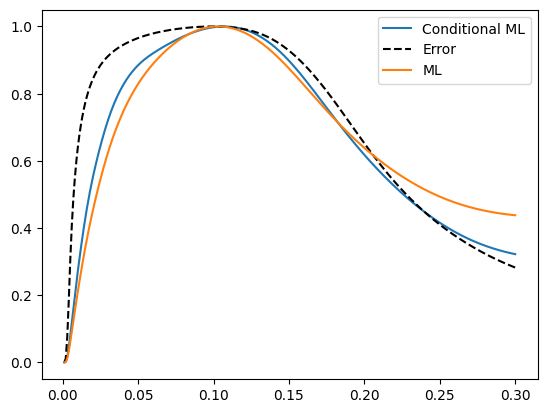

In [15]:
plt.plot(lengthscale_array, rescale(all_cml_ll.mean(0)), label="Conditional ML")
plt.plot(lengthscale_array, rescale(error_ll), "--k", label="Error")
plt.plot(lengthscale_array, rescale(ml_ll), label="ML")
plt.legend()